In [1]:
import os
import sys

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd

from move_direction import move_abs_direction
from move_length import move_length
from data_preprocessing import *
from helpers import traject_to_coord

from plot_helpers import plot_path

import matplotlib.pyplot as plt
%matplotlib inline

Let's load the data of users doing some routine web-surfing tasks such as: 
- reading Wikipedia, 
- checking news, 
- searching a route on maps, 
- watching YouTube,
- checking a social network (vk)
- or going through Pinterest search results.

While performing the tasks, their eye-movements were recorded with eye-tracker. And `x`, `y` variables denote gaze position on a screen, `time` determines time from the beginning of the recording to the current observation.

Position `(0, 0)` means the left upper corner of the screen.

The data was cleaned: only fixations were left and observations where a blink was detected were removed.

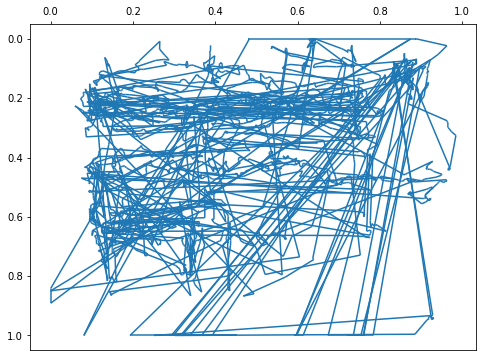

(108105, 5)


,x,y,time,user,task
0,0.38849,0.02145,0.20605,0,wiki
1,0.38830,0.04004,0.23047,0,wiki
2,0.38614,0.04428,0.26855,0,wiki
3,0.38614,0.04428,0.26855,0,wiki
4,0.38749,0.04990,0.34180,0,wiki


In [2]:
raw_df = pd.read_csv('demo_data/demo_data.csv')

p = plot_path(raw_df[['x', 'y']].values[:5000], figsize=(8, 6))
plt.savefig('imgs/et_data.png')
plt.show()

print(raw_df.shape)
raw_df.head()

## Data preprocessing

removed jittering (96870, 5)


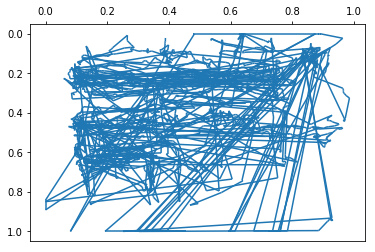

In [3]:
# To simplify the processing let's filter all movements which are less than delta

df = remove_tiny_moves(raw_df, delta=0.001)
print("removed jittering", df.shape)
p = plot_path(df[['x', 'y']].values[:5000])
plt.show()

## Compute features

In [4]:
x = df.x.values
y = df.y.values

# Find move direction, which can be calculated by checking the change from previous to current gaze position
# 12 o'clock vector will be used as a staring point, from which we are going clockwise. 
directions = move_abs_direction(x, y, invert_y=True, radians=True)
# add one 0 value to make the vector lengths equel with the rest of the data
df['move_dir'] = np.insert(directions, 0, 0) 
df['move_dir_norm'] = norm_values(df['move_dir'], 0, 2 * np.pi) # normalize data from zero to one, max=2pi

# Find length os path between previous position and the current one
lenghts = move_length(x, y)
df['move_len'] = np.insert(lenghts, 0, 0)
df['move_len_norm'] = norm_values(df['move_len'], 0, 1.44) # normalize data from zero to one, max=sqrt(2)

## We also may check the time
# move_time = (df.time - df.time.shift()).fillna(0)
# move_time[move_time < 0] = 0
# df['move_time'] = move_time
# norm time?

print(df.shape)
df.head()

(96870, 9)


,x,y,time,user,task,move_dir,move_dir_norm,move_len,move_len_norm
0,0.38849,0.02145,0.20605,0,wiki,0.000000,0.000000,0.000000,0.000000
1,0.38830,0.04004,0.23047,0,wiki,3.151818,0.501627,0.018591,0.012910
2,0.38614,0.04428,0.26855,0,wiki,3.612759,0.574989,0.004758,0.003305
4,0.38749,0.04990,0.34180,0,wiki,2.905845,0.462480,0.005780,0.004014
5,0.38321,0.12272,0.37012,0,wiki,3.200300,0.509344,0.072946,0.050657


## Check the data and save

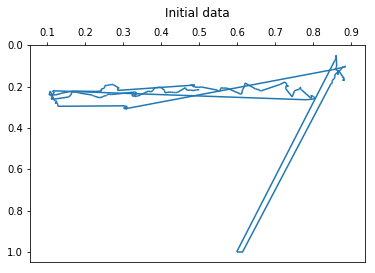

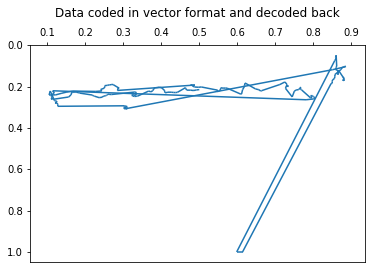

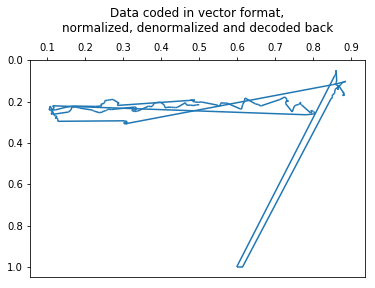

In [5]:
# Check if we can restore data from the normalization

ss, se = 100, 350 # range to check

# initial data
test_xy = df[['x', 'y']][ss-1:se].values
x_init = test_xy[0, 0] # first point location
y_init = test_xy[0, 1]

p = plot_path(test_xy, title="Initial data")
plt.show()

# data coded in vector direction and length
test_vec = df[['move_dir', 'move_len']][ss:se].values
xy = traject_to_coord(test_vec[:, 0], test_vec[:, 1], x_init, y_init)
p = plot_path(xy, title="Data coded in vector format and decoded back")
plt.show()

# data coded in vector direction and length, normalized, denormalized and decoded back
test_norm = df[['move_dir_norm', 'move_len_norm']][ss:se].values
md = denorm(test_norm[:, 0], x_max=2*np.pi)
ml = denorm(test_norm[:, 1], x_max=1.44)
xy = traject_to_coord(md, ml, x_init, y_init)
p = plot_path(xy, title="Data coded in vector format,\nnormalized, denormalized and decoded back")
plt.show()

# Looks like everything is OK, so we can save the data and proceed to the most interesting part :) 

In [6]:
# Save the data 
df.to_csv('demo_data/data.csv', index=False)